<a href="https://colab.research.google.com/github/Doppler-67/car-price-prediction/blob/main/autos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Importing libraries**

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import shap

from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

from lightgbm import LGBMRegressor
from xgboost import XGBRegressor

import warnings
warnings.filterwarnings('ignore')

In [2]:
sns.set()

# **Data understanding**

**План исследования:**


1.   Загрузить данные.
2.   Провести предобработку данных.
3.   Провести исследовательский анализ данных.
4.   Протестировать различные модели.
5.   Подобрать оптимальные параметры для моделей.
6.   Выбрать лучшую модель и проверить ее на тестовых данных.
7.   Провести интерпретацию лучшей модели.
8.   Сделать вывод о результатах.



In [3]:
data = pd.read_csv('/content/drive/MyDrive/autos_ds_project/autos.csv')

In [4]:
data.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  NotRepaired        283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

In [6]:
data.describe()

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


Нам доступно 354369 строк данных. Приступим в предобработке данных.

# **Data preparation**

Для начала исправим названия колонок (уберем заглавные символы и применим змеиный регистр).

In [7]:
data.columns = ['date_crawled', 'price', 'vehicle_type', 'registration_year', 
                'gearbox','power', 'model', 'kilometer', 'registration_month',
                'fuel_type', 'brand', 'is_repaired', 'date_created', 
                'number_of_pictures', 'postal_code', 'last_seen']

Теперь подправим типы данных.

In [8]:
dt_cols = ['date_crawled', 'date_created', 'last_seen'] 
data[dt_cols] = data[dt_cols].apply(pd.to_datetime)

In [9]:
int_cols = ['price', 'registration_year', 'power', 'kilometer', 'registration_month', 'number_of_pictures', 'postal_code']
data[int_cols] = data[int_cols].astype('int32')

In [10]:
data['is_repaired'] = data['is_repaired'].fillna('unknown')

В колонке is_repaired присуствует много пропусков. Так как эта колонка содержит всего две категории ( yes и no), то присвоим пропускам категорию - 'unknown'.

Проанализируем колонку number_of_pictures.

In [11]:
data['number_of_pictures'].unique()

array([0], dtype=int32)

Как мы видим в колонке number_of_pictures все значения равны 0. Уадлим ее, так как данная колонка бесполезна.

In [12]:
data = data.drop('number_of_pictures', axis = 1)

Изучим колонку date_created.




In [13]:
data['date_created'].dt.year.value_counts()

2016    354343
2015        25
2014         1
Name: date_created, dtype: int64

В датасете в основном анкеты были созданы в 2016 году.

Нам не понадобятся колонки date_crawled, date_created, last_seen, так как они никакой полезной информации в себе не несут. Поэтому удалим их.

In [14]:
data = data.drop(['date_crawled', 'date_created', 'last_seen'], axis = 1)

Изучим колонку registration_year.

In [15]:
data['registration_year'].min()

1000

In [16]:
data['registration_year'].max()

9999

Присутсвует много странных значений. Например, как-будто кто-то зарегестрировал автомобиль в 1400 году, хотя тогда автомобилей вообще не существовало или кто-то зарегестрировал автомобиль в 8200 году, хотя в колонке даты создания анкеты максимальный год - 2016.

Удалим все строки с годом регистрации автомобиля больше 2016 года и меньше 1970 года.

In [17]:
data = data[(data['registration_year'] < 2017) & (data['registration_year'] >= 1970)]

Изучим колонку vehicle_type.

In [18]:
data['vehicle_type'].value_counts()

sedan          91018
small          79718
wagon          65120
bus            28742
convertible    20085
coupe          15984
suv            11912
other           3205
Name: vehicle_type, dtype: int64

In [19]:
data['vehicle_type'].isna().sum()

22717

Пропусков много. Поступим с ними также, как в колонке is_reapired.

In [20]:
data['vehicle_type'] = data['vehicle_type'].fillna('unknown')

В данных присутсвуют строки в которых цена машины равна нулю. Такого быть не может, поэтому удалим их.

In [21]:
len(data[data['price'] == 0])

9858

In [22]:
data = data[data['price'] != 0]

В колонке power тоже много нулевых значений. Можно попробовать как-нибудь спарсить значение лошадиных сил по имеющейся марке и модели автомобиля. Такой вариант потребует много времени и усилий. Попробуем что-то попробще. Так как это не категориальная колонка, то мы не можем просто создать новую категорию 'unknown', поэтому просто удалим эти строки.

In [23]:
len(data[data['power'] == 0])

32465

In [24]:
data = data[data['power'] != 0]

Еще в колонке power много странных значений. Например 20к лошадиных сил.

In [25]:
data['power'].max()

20000

In [26]:
data['power'].median()

111.0

Удалим строки с лошадиными силами выше 1000. Если что потом в EDA еще по лучше подправим посмотрев на гистрограмму.

In [27]:
data = data[data['power'] <= 1000]

Изучим колонку brand.

In [28]:
data['brand'].value_counts()

volkswagen        64057
opel              32487
bmw               32267
mercedes_benz     27285
audi              25632
ford              20650
renault           13937
peugeot            9413
fiat               7644
seat               5861
skoda              4945
mazda              4726
smart              4487
citroen            4247
nissan             4048
toyota             4014
hyundai            3110
mini               2964
volvo              2795
mitsubishi         2499
honda              2365
kia                2088
alfa_romeo         1973
suzuki             1966
sonstige_autos     1665
chevrolet          1438
chrysler           1158
dacia               801
subaru              647
porsche             621
daihatsu            616
jeep                565
saab                474
land_rover          462
jaguar              436
daewoo              411
lancia              382
rover               367
trabant             258
lada                157
Name: brand, dtype: int64

Очень много разных брендов. Оставим только 18 самых популярных, а остальных закинем в категорию 'other'.

In [29]:
top18 = data['brand'].value_counts()[:18].index
data['brand'] = data['brand'].apply(lambda x: 'other' if x not in top18 else x)

Изучим  колонку fuel_type.

In [30]:
data['fuel_type'].value_counts()

petrol      187006
gasoline     87835
lpg           4684
cng            483
hybrid         202
other           88
electric        76
Name: fuel_type, dtype: int64

In [31]:
data['fuel_type'].isna().sum()

15544

Также много пропусков. Заполним их значением 'unknown'.

In [32]:
data['fuel_type'] = data['fuel_type'].fillna('unknown')

Изучим колонку model.

In [33]:
data['model'].value_counts()

golf                  24728
other                 20127
3er                   17387
polo                  10696
corsa                 10134
                      ...  
samara                    5
serie_2                   4
serie_3                   3
rangerover                2
range_rover_evoque        2
Name: model, Length: 249, dtype: int64

В данной колонки слишком много категорий. Оставим только 20 самых пополярных, а остальных поместим в категорию 'other'.

In [34]:
top20 = data['model'].value_counts()[:21].index # 21 потому что в этом топе присуствует значение other.

In [35]:
data['model'] = data['model'].apply(lambda x: 'other' if x not in top20 else x)

In [36]:
data['model'].isna().sum()

0

In [37]:
#data['model'] = data['model'].fillna('unknown')

Изучим колонку gearbox.

In [38]:
data['gearbox'].value_counts()

manual    231749
auto       58817
Name: gearbox, dtype: int64

In [39]:
data['gearbox'].isna().sum()

5352

В колонке gearbox пропусков незначительное кол-во. Можно заполнить пропуски значением 'auto', чтобы немного уменьшить дисбаланс классов, но давайте не будет искажать данные и просто удалим пропуски.

In [40]:
data = data.dropna(subset=['gearbox'])

Предобработка завершена. Посмотрим на предобработанные данные и перейдем к EDA.

In [41]:
data.head()

,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,is_repaired,postal_code
1,18300,coupe,2011,manual,190,other,125000,5,gasoline,audi,yes,66954
2,9800,suv,2004,auto,163,other,125000,8,gasoline,other,unknown,90480
3,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,91074
4,3600,small,2008,manual,69,other,90000,7,gasoline,skoda,no,60437
5,650,sedan,1995,manual,102,3er,150000,10,petrol,bmw,yes,33775


In [42]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 290566 entries, 1 to 354368
Data columns (total 12 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   price               290566 non-null  int32 
 1   vehicle_type        290566 non-null  object
 2   registration_year   290566 non-null  int32 
 3   gearbox             290566 non-null  object
 4   power               290566 non-null  int32 
 5   model               290566 non-null  object
 6   kilometer           290566 non-null  int32 
 7   registration_month  290566 non-null  int32 
 8   fuel_type           290566 non-null  object
 9   brand               290566 non-null  object
 10  is_repaired         290566 non-null  object
 11  postal_code         290566 non-null  int32 
dtypes: int32(6), object(6)
memory usage: 22.2+ MB


# **EDA**

Посмотрим на распределение колонки price.

Text(0.5, 1.0, 'price distribution')

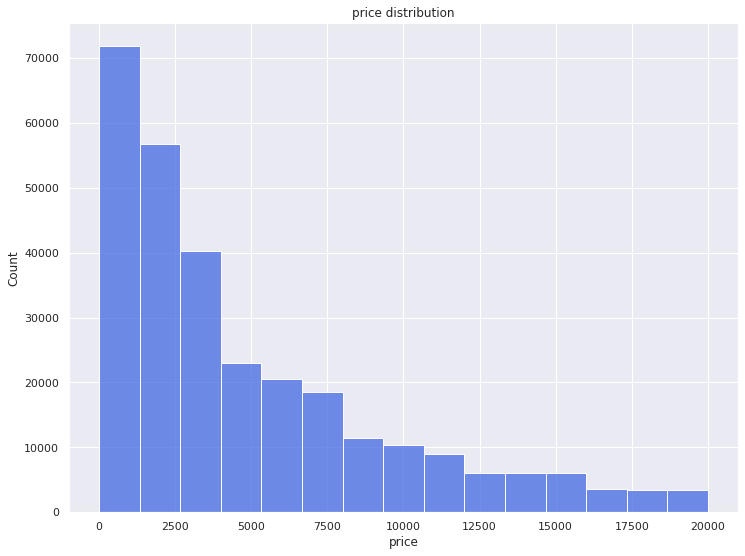

In [43]:
plt.figure(figsize=(12, 9))
sns.histplot(data['price'], bins=15, color='royalblue')
plt.title('price distribution')

Цена распределна экспоненциально. 

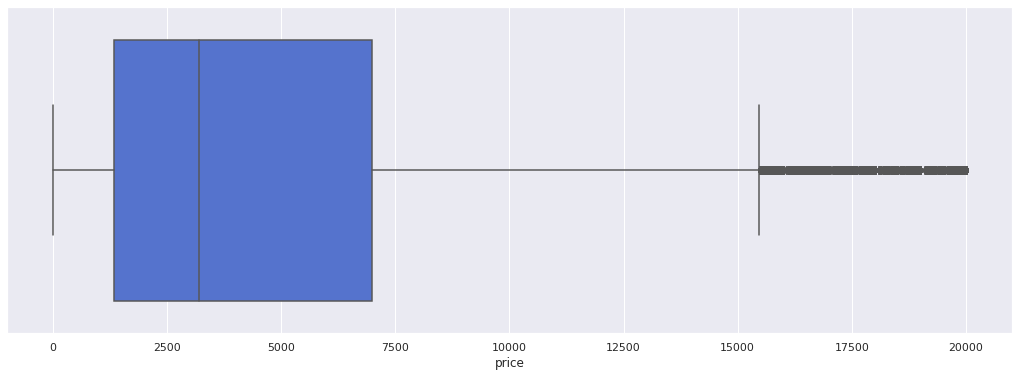

In [44]:
plt.figure(figsize=(18, 6))
sns.boxplot(data['price'], color='royalblue')

Text(0.5, 1.0, 'mileage distribution')

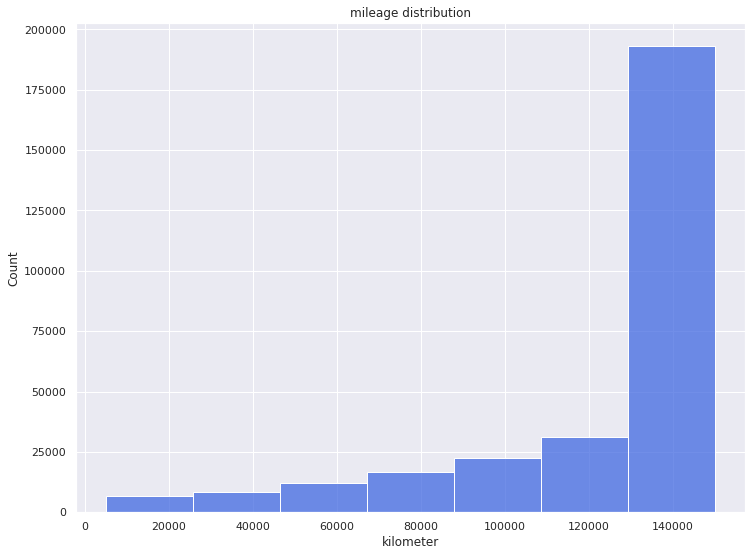

In [45]:
plt.figure(figsize=(12, 9))
sns.histplot(data['kilometer'], bins=7, color='royalblue')
plt.title('mileage distribution')

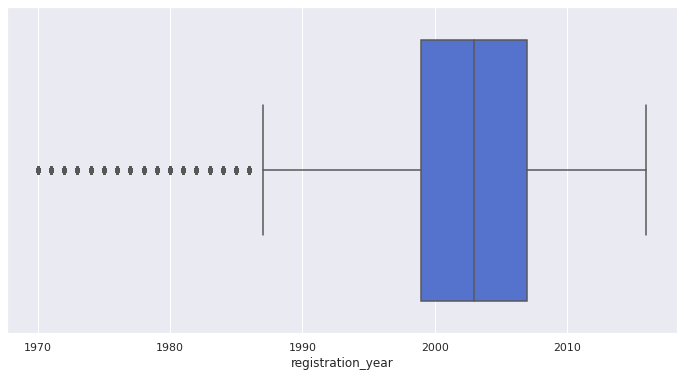

In [46]:
plt.figure(figsize=(12, 6))
sns.boxplot(data['registration_year'], color='royalblue')

В колонке registration_year присуствуют выбросы удалим их.

In [47]:
data = data[data['registration_year'] > 1986]

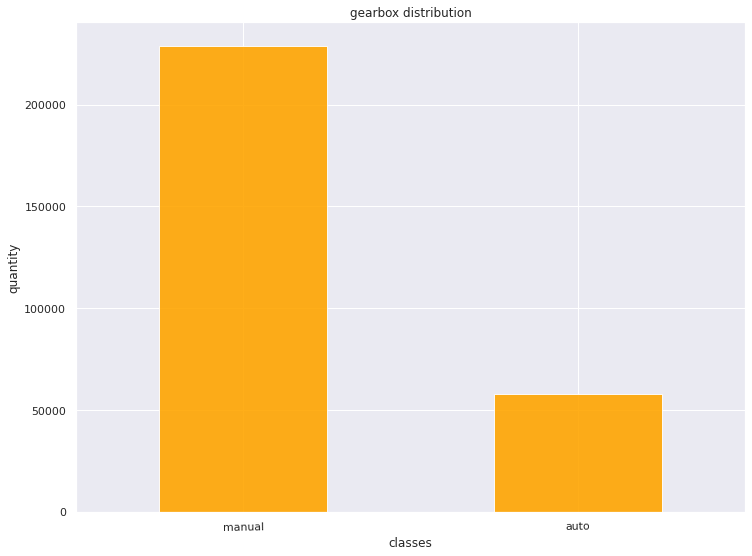

In [48]:
data['gearbox'].value_counts().plot(kind='bar', title='gearbox distribution', xlabel='classes', 
                                     ylabel='quantity', rot=1, color='orange', alpha =0.9, figsize=(12,9))

Text(0.5, 1.0, 'horsepower distribution')

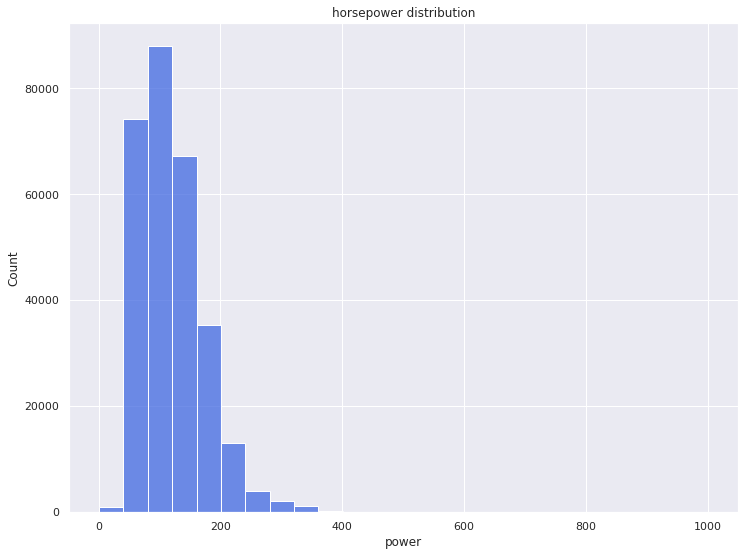

In [49]:
plt.figure(figsize=(12, 9))
sns.histplot(data['power'], bins=25,color='royalblue')
plt.title('horsepower distribution')

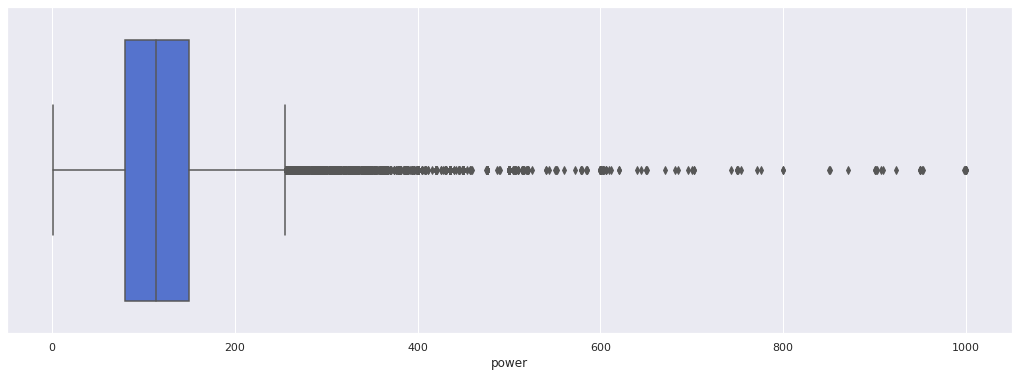

In [50]:
plt.figure(figsize=(18, 6))
sns.boxplot(data['power'], color='royalblue')

Удалим все строки с лошадиными силами больше 400.

Также сложно себе представить машины с <30 лошадиных сил. Поэтому эти строки тоже удалим.

In [51]:
data = data[(data['power'] <= 400) & (data['power'] >= 30)]

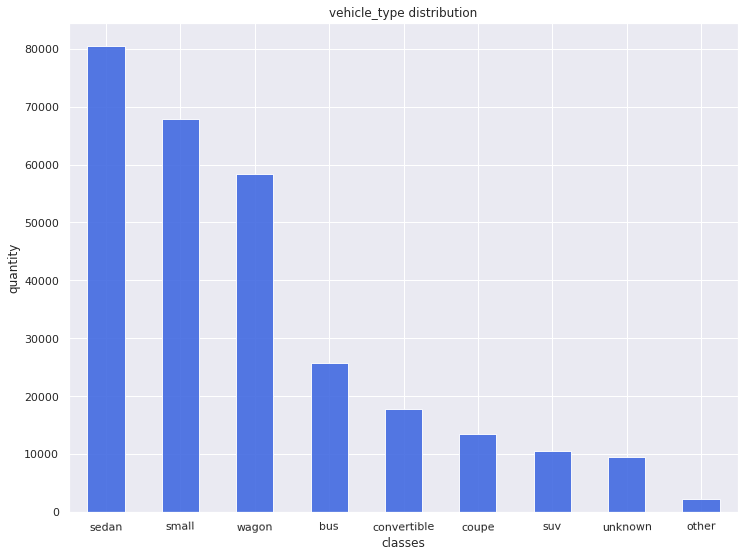

In [52]:
data['vehicle_type'].value_counts().plot(kind='bar', title='vehicle_type distribution', xlabel='classes', 
                                     ylabel='quantity', rot=1, color='royalblue', alpha =0.9, figsize=(12,9))

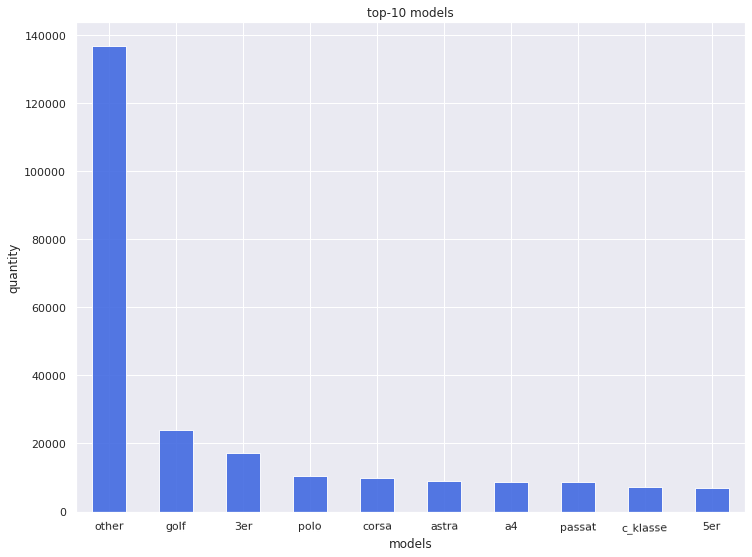

In [53]:
data['model'].value_counts()[:10].plot(kind='bar', title='top-10 models', xlabel='models', 
                                     ylabel='quantity', rot=1, color='royalblue', alpha =0.9, figsize=(12,9))

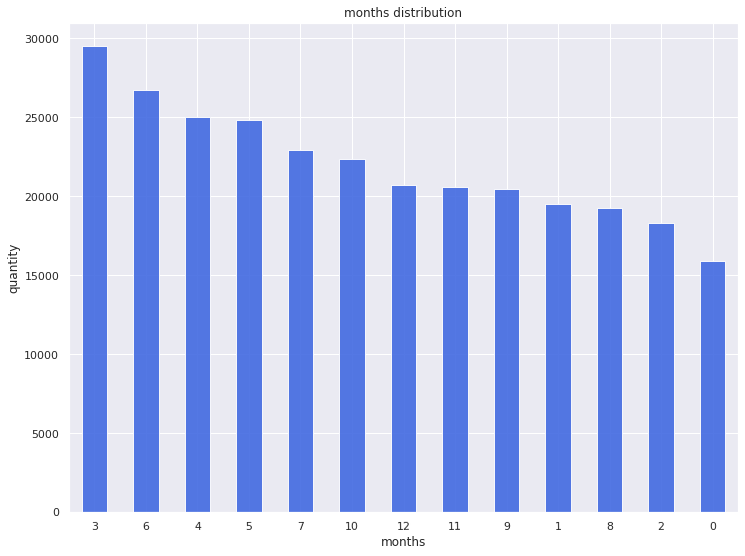

In [54]:
data['registration_month'].value_counts().plot(kind='bar', title='months distribution', xlabel='months', 
                                     ylabel='quantity', rot=1, color='royalblue', alpha =0.9, figsize=(12,9))

Самый частый месяц регистрации автомобиля - март.

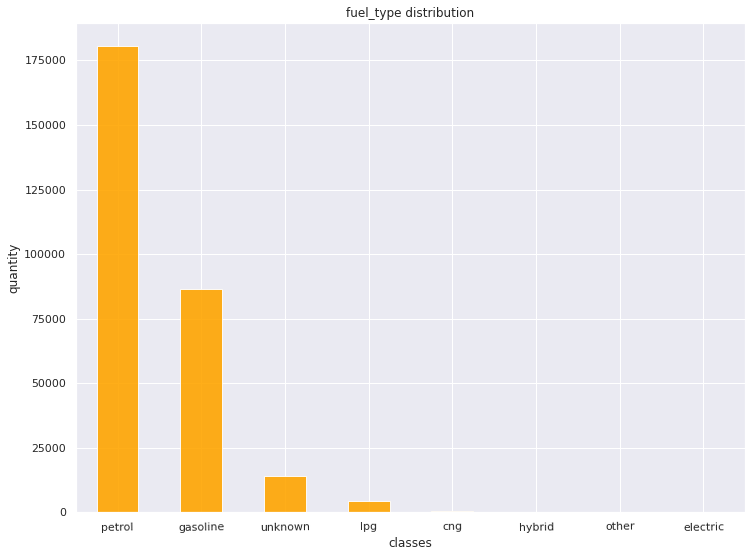

In [55]:
data['fuel_type'].value_counts().plot(kind='bar', title='fuel_type distribution', xlabel='classes', 
                                     ylabel='quantity', rot=1, color='orange', alpha =0.9, figsize=(12,9))

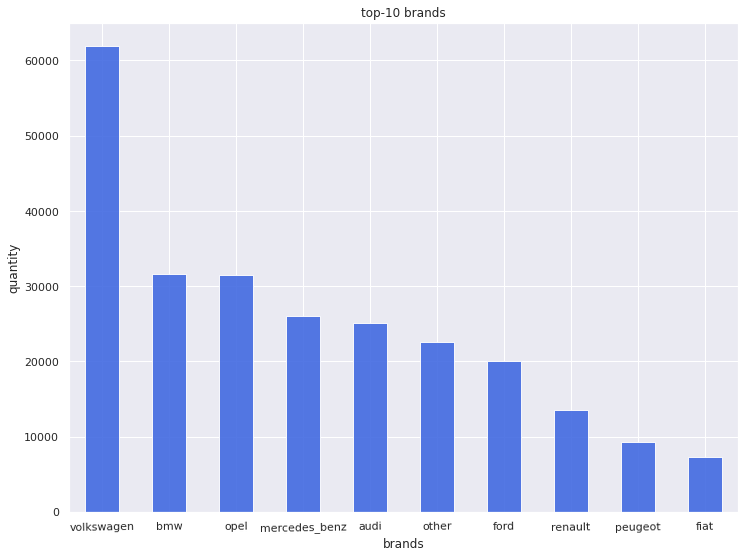

In [56]:
data['brand'].value_counts()[:10].plot(kind='bar', title='top-10 brands', xlabel='brands', 
                                     ylabel='quantity', rot=1, color='royalblue', alpha =0.9, figsize=(12,9))

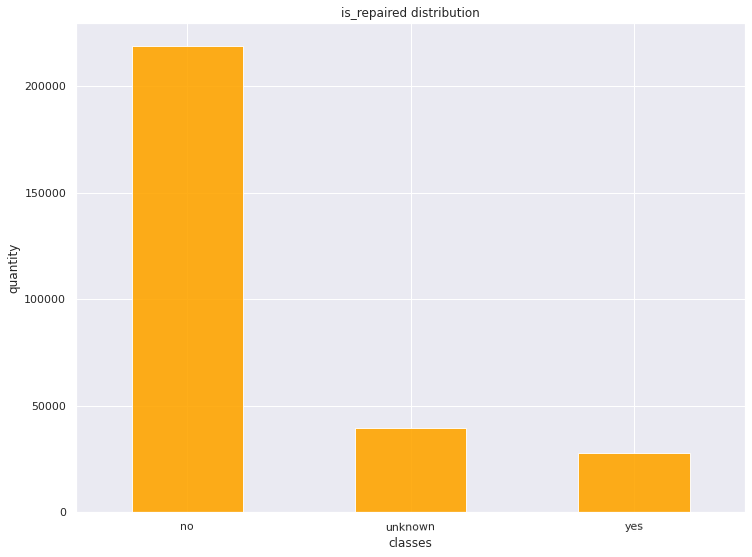

In [57]:
data['is_repaired'].value_counts().plot(kind='bar', title='is_repaired distribution', xlabel='classes', 
                                     ylabel='quantity', rot=1, color='orange', alpha =0.9, figsize=(12,9))

Применим технику label encoding для категориальных колонок.

In [58]:
cat_cols = ['vehicle_type', 'gearbox', 'model', 'fuel_type', 'brand', 'is_repaired']
enc = OrdinalEncoder()
data[cat_cols] = enc.fit_transform(data[cat_cols])

Теперь посмотрим на корреляции.

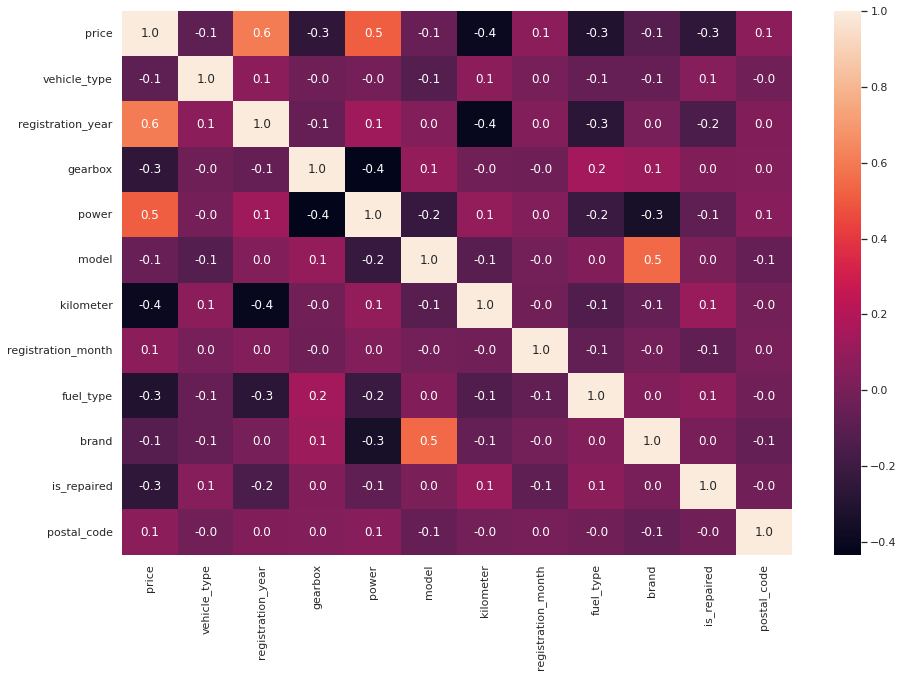

In [59]:
plt.figure(figsize=(15, 10))
sns.heatmap(data.corr(), annot=True, fmt=".1f")

Есть значимая корреляция между кол-вом лощадиных сил и ценой автомобиля, между ценой автомобиля и годом регистрации, между брендом и моделью.

# **Modeling**

Сначала разделим выборку в пропорции 1:4. 4 части будет использовано для кросс-валидации, а 1 часть - для теста.

In [60]:
features = data.drop('price', axis=1)
target = data['price']

In [61]:
x_train, x_test, y_train, y_test = train_test_split(features, target, train_size=0.8, random_state=67)

**baseline**

В качестве бейзлайна возьмем случайный лес.

In [62]:
model = RandomForestRegressor(random_state=67)

In [63]:
%%time
cross_val_score(model, x_train, y_train, cv=5, scoring='neg_root_mean_squared_error')

CPU times: user 6min 27s, sys: 2.61 s, total: 6min 29s
Wall time: 6min 40s


array([-1511.57237148, -1518.91008605, -1507.28232418, -1499.63415549,
       -1532.04668704])

Как мы видим модель довольно стабильна.

Так как нам важно не только качество предсказаний, а еще и скорость обучения и скорость предсказания, то протестируем две модели: lightgmb и xgboost.

Нам важен баланс между качеством предсказаний и скоростью обучения. Очевидно, что модель lightgbm будет обучаться быстрее всех - это ее основаня фишка, но если у нее будет плохое качество, то придется пожертвовать скоростью обучения ради качества распознавания.

Сначала посмотрим, как эти модели покажут себя в стоке, а потому уже займемся тюнингом гиперпараметров.

In [64]:
model = LGBMRegressor(random_state=67)

In [65]:
%%time
scores = cross_val_score(model, x_train, y_train, cv=5, scoring='neg_root_mean_squared_error')

CPU times: user 16.3 s, sys: 372 ms, total: 16.7 s
Wall time: 8.92 s


In [66]:
print(scores)
print('avg nrmse:', round(sum(scores) / len(scores)))

[-1630.23234555 -1632.71134934 -1616.96379299 -1625.59145687
 -1647.50512127]
avg nrmse: -1631


In [67]:
model = XGBRegressor(random_state=67, objective="reg:squarederror")

In [68]:
%%time
scores = cross_val_score(model, x_train, y_train, cv=5, scoring='neg_root_mean_squared_error')

CPU times: user 41.4 s, sys: 314 ms, total: 41.7 s
Wall time: 41.4 s


In [69]:
print(scores)
print('avg nrmse:', round(sum(scores) / len(scores)))

[-1816.34593638 -1809.54908448 -1807.5855484  -1817.11363357
 -1844.16841886]
avg nrmse: -1819


модель lgbm показал себя лучше модели xgboost как в качестве, так и в скорости обучения. Но это еще не показатель, так как модели тестировались в стоковом состоянии.

Обе модели не дотягивают до нашего бейзлайна по качеству предсказаний.

**Hyperparameter tuning**

In [70]:
params = {
    'learning_rate': np.arange(0.05, 0.31, 0.05),
    'max_depth': np.arange(3, 13, 1, dtype=int),
    'min_child_weight': np.arange(1, 8, 1, dtype=int),
    'colsample_bytree': np.arange(0.3, 0.8, 0.1),
    'n_estimators': np.arange(100, 500, 25)
}

In [71]:
model = XGBRegressor(random_state=67, objective="reg:squarederror", tree_method='gpu_hist')
rs_model = RandomizedSearchCV(model, param_distributions=params, 
                              scoring='neg_root_mean_squared_error', n_jobs=-1, cv=3, 
                              verbose=3, n_iter=20, random_state=67)
rs_model.fit(x_train, y_train)
rs_model.best_params_

Fitting 3 folds for each of 20 candidates, totalling 60 fits


{'colsample_bytree': 0.4,
 'learning_rate': 0.15000000000000002,
 'max_depth': 12,
 'min_child_weight': 3,
 'n_estimators': 175}

In [72]:
scores = cross_val_score(rs_model.best_estimator_, x_train, y_train, cv=5, scoring='neg_root_mean_squared_error')
print(scores)
print('avg nrmse:', round(sum(scores) / len(scores)))

[-1481.33949815 -1494.49016528 -1472.66000921 -1483.45237594
 -1501.58668298]
avg nrmse: -1487


In [73]:
model = LGBMRegressor(random_state=67)
rs_model = RandomizedSearchCV(model, param_distributions=params, 
                              scoring='neg_root_mean_squared_error', n_jobs=-1, cv=3, 
                              verbose=3, n_iter=20, random_state=67)
rs_model.fit(x_train, y_train)
rs_model.best_params_

Fitting 3 folds for each of 20 candidates, totalling 60 fits


{'colsample_bytree': 0.5,
 'learning_rate': 0.3,
 'max_depth': 12,
 'min_child_weight': 1,
 'n_estimators': 450}

In [74]:
scores = cross_val_score(rs_model.best_estimator_, x_train, y_train, cv=5, scoring='neg_root_mean_squared_error')
print(scores)
print('avg nrmse:', round(sum(scores) / len(scores)))

[-1535.93282846 -1547.2128521  -1524.73179677 -1520.9711735
 -1551.12963113]
avg nrmse: -1536


Результаты моделей улучшились.

Так как результаты отличаются незначительно, а скорость обучения у lgbm значительно выше, то в качестве основной модели выберем именно lgbm.

# **Testing**

Теперь проверим модель lgbm на тестовой выборке.

In [75]:
model = rs_model.best_estimator_
model.fit(x_train, y_train)
print('rmse: ',mean_squared_error(y_test, model.predict(x_test)) ** 0.5)

rmse:  1517.4084925043146


Результат почти такой же как и на кросс-валидации. Это говорит о том, что модель хорошо обучилась и никакого underfit`a и overfit`a нет.

# **Results**

Теперь приступим к анализу модели.

Для того, чтобы интерпритировать модель максимально четко - обучим ее на полных данных. Для этого просто соеденим train и test.

In [76]:
x_train_and_test = pd.concat([x_train, x_test])
y_train_and_test = pd.concat([y_train, y_test])

Обучим модель на полных данных.

In [77]:
model.fit(x_train_and_test, y_train_and_test)

LGBMRegressor(colsample_bytree=0.5, learning_rate=0.3, max_depth=12,
              min_child_weight=1, n_estimators=450, random_state=67)

Для интерпритации модели будем использовать библиотеку shap.

In [78]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(x_train_and_test)

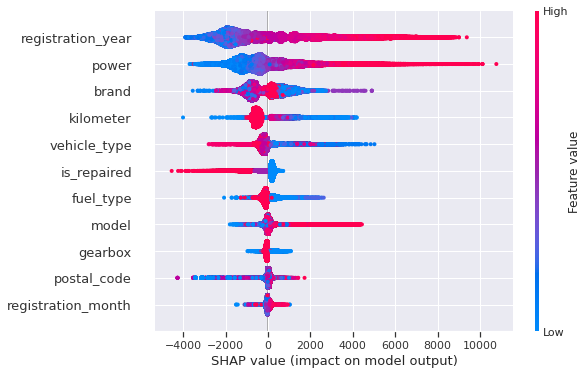

In [79]:
shap.summary_plot(shap_values, x_train_and_test)

По данному графику видно, что модель добавляет цену машине : при высоких значениях года регистрации машины, при высоких значениях лошадиных сил, при низких значениях пробега и когда машина не ремонтировалась. 

Теперь посмотрим значимость фичей для модели.

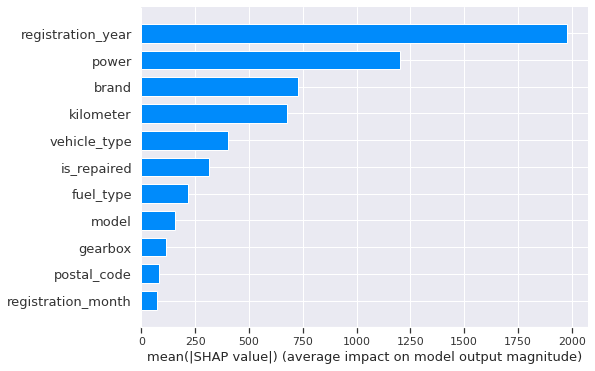

In [80]:
shap.summary_plot(shap_values, x_train_and_test, plot_type="bar")

На первом месте по значимости у нас - год регистрации автомобиля, на втором - лошадиные силы и на третьем - бренд автомобиля.

# **Conclusion**

<b> В итоге лучшей моделью оказалась модель lgbm. Она показала практически такие-же результаты, как модель xgboost, при этом скорость обучения у модели lgbm значительно выше, чем у модели xgboost. Удалось достичь значения 1517 по метрике RMSE на тестовой выборке. Учитывая, что стандартное отклонение у price - 4500, то наша модель отлично справилась. Также было проанализировано: значимость фичей для модели и при каких значениях фичей модель принимала решение повысить цену автомобилю.</b>